In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [3]:
import warnings
warnings.simplefilter('ignore')

In [4]:
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
TARGET = "SalePrice"

CATS = train.select_dtypes(include=['object', 'category']).columns.tolist()
NUMS = train.select_dtypes(include=['number']).drop(columns=[TARGET], errors='ignore').columns.tolist()
FEATURES = CATS + NUMS

print("TARGET:", TARGET)
print("\nCATEGORICAL FEATURES:", CATS)
print("\nNUMERICAL FEATURES:", NUMS)

TARGET: SalePrice

CATEGORICAL FEATURES: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

NUMERICAL FEATURES: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'G

In [6]:
import xgboost as xgb
from xgboost import XGBRegressor

print("XGBoost Version:", xgb.__version__)

XGBoost Version: 2.0.3


In [7]:
train_df = train.copy()
test_df = test.copy()

train_df[CATS] = train_df[CATS].fillna("Missing").astype("category")
test_df[CATS] = test_df[CATS].fillna("Missing").astype("category")

In [8]:
%%time

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds_xgb = np.zeros(len(train_df))
test_preds_xgb = np.zeros(len(test_df))

xgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "max_depth": 6,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "random_state": 42,
    # "tree_method": "gdp_hist", # if using GPU
    "enable_categorical": True
}

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    print(f"### Fold {fold+1} ###")

    X_train, y_train = train_df.iloc[train_idx][FEATURES], train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df.iloc[valid_idx][FEATURES], train_df.iloc[valid_idx][TARGET]
    X_test = test_df[FEATURES]

    model = XGBRegressor(**xgb_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=50,
        verbose=500
    )

    oof_preds_xgb[valid_idx] = model.predict(X_valid)
    test_preds_xgb += model.predict(X_test) / FOLDS

rmse = np.sqrt(mean_squared_error(train_df[TARGET], oof_preds_xgb))
print(f"Validation RMSE: {rmse}")


### Fold 1 ###
[0]	validation_0-rmse:86221.78112
[500]	validation_0-rmse:23865.15448
[642]	validation_0-rmse:23818.48103
### Fold 2 ###
[0]	validation_0-rmse:81257.01715
[500]	validation_0-rmse:24701.69727
[526]	validation_0-rmse:24703.43341
### Fold 3 ###
[0]	validation_0-rmse:73090.83154
[149]	validation_0-rmse:36628.86409
### Fold 4 ###
[0]	validation_0-rmse:78180.76889
[500]	validation_0-rmse:28579.79698
[508]	validation_0-rmse:28585.27859
### Fold 5 ###
[0]	validation_0-rmse:71228.81585
[500]	validation_0-rmse:25363.13389
[645]	validation_0-rmse:25349.49509
Validation RMSE: 27900.564957084283
CPU times: user 38 s, sys: 249 ms, total: 38.2 s
Wall time: 9.91 s


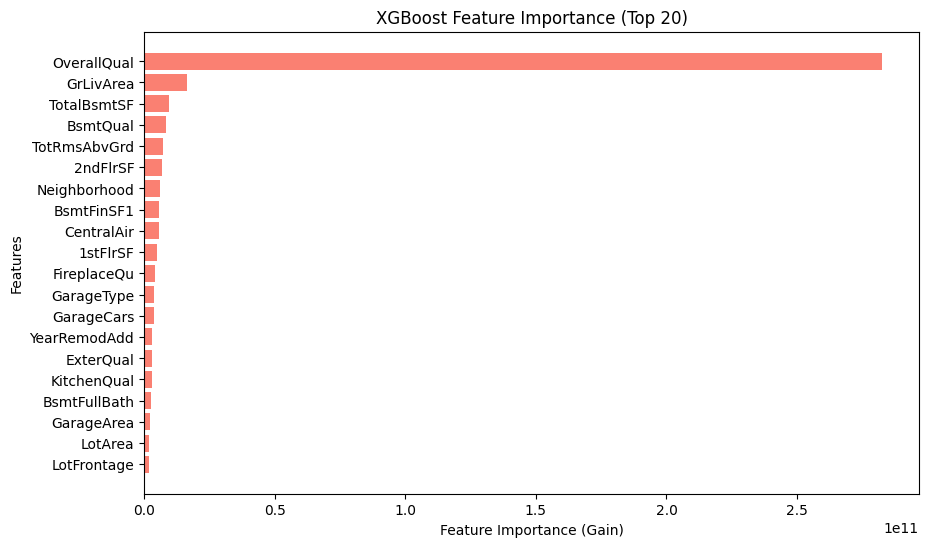

In [9]:
# XGBoost Feature Importance
xgb_importance = model.get_booster().get_score(importance_type="gain")
xgb_importance_df = pd.DataFrame(list(xgb_importance.items()), columns=["Feature", "Importance"])
xgb_importance_df = xgb_importance_df.sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10, 6))
plt.barh(xgb_importance_df["Feature"], xgb_importance_df["Importance"], color="salmon")
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance (Top 20)")
plt.gca().invert_yaxis()
plt.show()


In [10]:
import lightgbm as lgb
from lightgbm import LGBMRegressor

print("LightGBM Version:", lgb.__version__)

LightGBM Version: 4.5.0


In [11]:
train_df = train.copy()
test_df = test.copy()

train_df[CATS] = train_df[CATS].fillna("Missing").astype("category")
test_df[CATS] = test_df[CATS].fillna("Missing").astype("category")

In [12]:
%%time

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds_lgb = np.zeros(len(train_df))
test_preds_lgb = np.zeros(len(test_df))

lgb_params = {
    "n_estimators": 2000,
    "learning_rate": 0.02,
    "max_depth": 6,
    "objective": "regression",
    "metric": "rmse",
    "random_state": 42,
    "verbose": -1,
    # "device": "gpu",  # GPU
}

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    print(f"### Fold {fold+1} ###")

    X_train, y_train = train_df.iloc[train_idx][FEATURES], train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df.iloc[valid_idx][FEATURES], train_df.iloc[valid_idx][TARGET]
    X_test = test_df[FEATURES]

    model = LGBMRegressor(**lgb_params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        categorical_feature=CATS,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(500)],
    )

    oof_preds_lgb[valid_idx] = model.predict(X_valid)
    test_preds_lgb += model.predict(X_test) / FOLDS

rmse = np.sqrt(mean_squared_error(train_df[TARGET], oof_preds_lgb))
print(f"Validation RMSE: {rmse}")


### Fold 1 ###
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 28641.8
Early stopping, best iteration is:
[726]	valid_0's rmse: 28096.9
### Fold 2 ###
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[262]	valid_0's rmse: 25614
### Fold 3 ###
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 35029
### Fold 4 ###
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's rmse: 26131.8
### Fold 5 ###
Training until validation scores don't improve for 50 rounds
[500]	valid_0's rmse: 20852.3
Early stopping, best iteration is:
[617]	valid_0's rmse: 20730
Validation RMSE: 27514.157447458587
CPU times: user 4.32 s, sys: 153 ms, total: 4.47 s
Wall time: 2.35 s


In [13]:
def plot_feature_importance(importances, feature_names, model_name, top_n=20):
    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    importance_df = importance_df.sort_values(by="Importance", ascending=False).head(top_n) 

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df["Feature"], importance_df["Importance"], color="skyblue")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.title(f"{model_name} Feature Importance (Top {top_n})")
    plt.gca().invert_yaxis()
    plt.show()

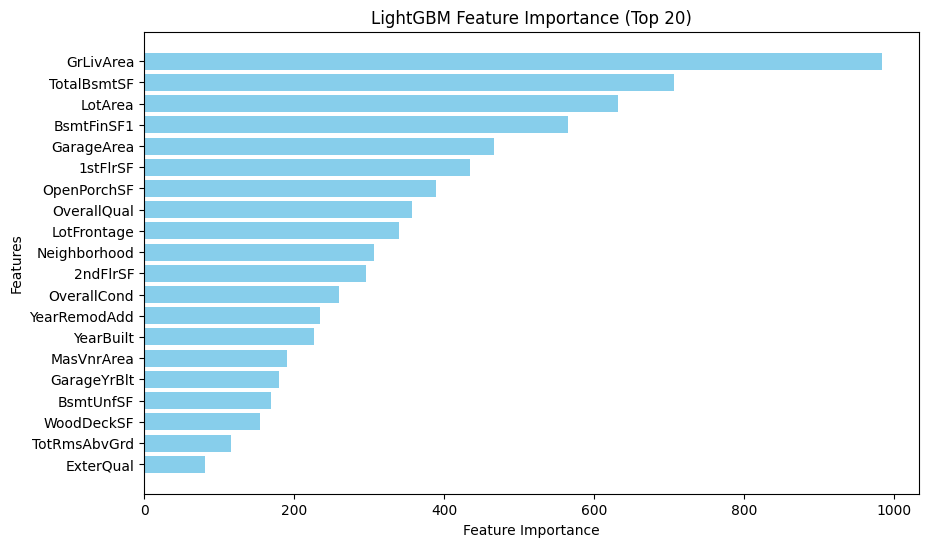

In [14]:
plot_feature_importance(model.feature_importances_, FEATURES, "LightGBM")

In [15]:
import catboost as cbt
from catboost import CatBoostRegressor

print("CatBoost Version:", cbt.__version__)

CatBoost Version: 1.2.7


In [16]:
train_df = train.copy()
test_df = test.copy()

train_df[CATS] = train_df[CATS].astype(str)
test_df[CATS] = test_df[CATS].astype(str)

In [17]:
%%time

FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof_preds_cat = np.zeros(len(train_df))
test_preds_cat = np.zeros(len(test_df))

catboost_params = {
    "iterations": 2000,
    "learning_rate": 0.02,
    "depth": 6,
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "cat_features": CATS,
    "verbose": 500
}

for fold, (train_idx, valid_idx) in enumerate(kf.split(train_df)):
    print(f"### Fold {fold+1} ###")

    X_train, y_train = train_df.iloc[train_idx][FEATURES], train_df.iloc[train_idx][TARGET]
    X_valid, y_valid = train_df.iloc[valid_idx][FEATURES], train_df.iloc[valid_idx][TARGET]
    X_test = test_df[FEATURES]

    model = CatBoostRegressor(**catboost_params)
    model.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

    oof_preds_cat[valid_idx] = model.predict(X_valid)
    test_preds_cat += model.predict(X_test) / FOLDS

rmse = np.sqrt(mean_squared_error(train_df[TARGET], oof_preds_cat))
print(f"Validation RMSE: {rmse}")

### Fold 1 ###
0:	learn: 76277.9792898	test: 86643.3078284	best: 86643.3078284 (0)	total: 71ms	remaining: 2m 21s
500:	learn: 16242.9633269	test: 26845.6962464	best: 26845.6962464 (500)	total: 7.66s	remaining: 22.9s
1000:	learn: 12786.8573515	test: 26100.3558001	best: 26092.8209799 (994)	total: 15.8s	remaining: 15.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 25861.55236
bestIteration = 1385

Shrink model to first 1386 iterations.
### Fold 2 ###
0:	learn: 77637.6293659	test: 81652.4989264	best: 81652.4989264 (0)	total: 19.4ms	remaining: 38.8s
500:	learn: 16884.7379526	test: 24021.8651498	best: 24017.2645077 (499)	total: 8.12s	remaining: 24.3s
1000:	learn: 13013.1563297	test: 23103.0086092	best: 23094.9683610 (998)	total: 16.3s	remaining: 16.2s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 23068.57152
bestIteration = 1050

Shrink model to first 1051 iterations.
### Fold 3 ###
0:	learn: 79599.7400052	test: 73324.9210170	best: 73324.9210170 (0)	to

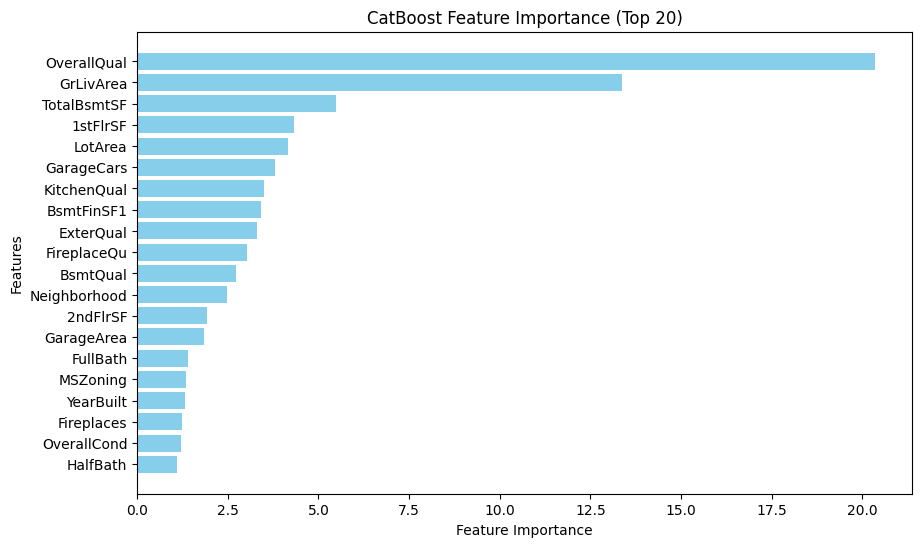

In [18]:
# CatBoost Feature Importance
cat_importance = model.get_feature_importance()
plot_feature_importance(cat_importance, FEATURES, "CatBoost")

In [19]:
from sklearn.linear_model import Ridge

In [20]:
%%time

X_train_stack = np.column_stack((oof_preds_xgb, oof_preds_lgb, oof_preds_cat))
y_train_stack = train_df[TARGET].values

X_test_stack = np.column_stack((test_preds_xgb, test_preds_lgb, test_preds_cat))

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_stack, y_train_stack)

oof_preds_stack = ridge.predict(X_train_stack)
test_preds_stack = ridge.predict(X_test_stack)

rmse_stack = np.sqrt(mean_squared_error(y_train_stack, oof_preds_stack))
print(f"Stacking Model Validation RMSE: {rmse_stack}")

Stacking Model Validation RMSE: 26094.44724702117
CPU times: user 20.9 ms, sys: 2.23 ms, total: 23.1 ms
Wall time: 26.3 ms


In [21]:
import scipy.optimize as opt

In [22]:
%%time

X_train_hill = np.column_stack((oof_preds_xgb, oof_preds_lgb, oof_preds_cat))
y_train_hill = train_df[TARGET].values
X_test_hill = np.column_stack((test_preds_xgb, test_preds_lgb, test_preds_cat))

def rmse_loss(weights):
    blended_preds = np.dot(X_train_stack, weights)
    return np.sqrt(mean_squared_error(y_train_hill, blended_preds))

init_weights = np.ones(X_train_stack.shape[1]) / X_train_stack.shape[1]
constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}

bounds = [(0, 1)] * X_train_stack.shape[1]

result = opt.minimize(rmse_loss, init_weights, method="SLSQP", bounds=bounds, constraints=constraints)

best_weights = result.x
print(f"Optimal Weights: {best_weights}")

oof_preds_hill = np.dot(X_train_stack, best_weights)
rmse_stack = np.sqrt(mean_squared_error(y_train_hill, oof_preds_hill))
print(f"Climb Hill Stacking Validation RMSE: {rmse_stack}")

test_preds_hill = np.dot(X_test_hill, best_weights)

Optimal Weights: [0.26494893 0.27589749 0.45915358]
Climb Hill Stacking Validation RMSE: 26328.984109268247
CPU times: user 10.5 ms, sys: 1.06 ms, total: 11.6 ms
Wall time: 10.9 ms


In [23]:
sub = pd.read_csv('/kaggle/input/home-data-for-ml-course/sample_submission.csv')
sub[TARGET] = test_preds_stack
sub.to_csv("submission.csv", index=False)